In [2]:
import os
import h5py
import pandas as pd
from tqdm import tqdm_notebook
import sys
import warnings
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

/home/jackalhan/Development/github/more_meaningful_representations/venv/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [ ]:
#dataset_type = 'train'
dataset_type = 'dev'
dataset_version = 'v1.1'

index_field = ['Unnamed: 0']

# required files
_basepath = '/home/jackalhan/Development/github/more_meaningful_representations/squad/'
datadir = os.path.join(_basepath, dataset_type)
modeldir = os.path.join(_basepath, 'model')

_qas_file_name = '{}_qas.csv'.format(dataset_type)
qas_file = os.path.join(datadir, _qas_file_name)

_embedding_mean_paragraph_file_as_h5py_name = 'elmo_{}_mean_paragraph_embeddings.hdf5'
embedding_mean_paragraph_file_as_h5py = os.path.join(datadir, _embedding_mean_paragraph_file_as_h5py_name)

_embedding_mean_question_file_as_h5py_name = 'elmo_{}_mean_question_embeddings.hdf5'
embedding_mean_question_file_as_h5py = os.path.join(datadir, _embedding_mean_question_file_as_h5py_name)

_cos_similarity_results_file_name =  '{}_cos_similarity_with_{}_norm_for_q_vs_para.csv'
cos_similarity_results_file_name = os.path.join(datadir, _cos_similarity_results_file_name)

_nearest_all_cos_similarity_results_file_name =  '{}_nearest_all_cos_similarity_with_{}_norm_for_q_vs_para.csv'
nearest_all_cos_similarity_results_file = os.path.join(datadir, _nearest_all_cos_similarity_results_file_name)

_cos_similarity_results_as_hist_file_name =  'histogram_{}_cos_similarity_with_{}_norm_for_q_vs_para.png'
cos_similarity_results_as_hist_file = os.path.join(datadir, _cos_similarity_results_as_hist_file_name)

_paragraphs_file_name_as_txt = '{}_paragraphs.txt'.format(dataset_type)
paragraphs_file_as_txt = os.path.join(datadir, _paragraphs_file_name_as_txt)

_questions_file_name_as_txt = '{}_questions.txt'.format(dataset_type)
questions_file_as_txt = os.path.join(datadir, _questions_file_name_as_txt)

df_qas = pd.read_csv(qas_file).set_index(index_field)

In [ ]:
p_look_up = []
q_look_up = []
with open(paragraphs_file_as_txt, 'r') as fp_in,open(questions_file_as_txt, 'r') as fq_in:
    for i, line in enumerate(fp_in):
        p_look_up.append((i, line.replace('\n','')))
    for i, line in enumerate(fq_in):
        q_look_up.append((i, line.replace('\n','')))
df_p_look_up = pd.DataFrame(data=p_look_up, columns=['id', 'paragraph']).set_index('id')
df_q_look_up = pd.DataFrame(data=q_look_up, columns=['id', 'question']).set_index('id')

In [ ]:
dims = 1024
items = [dict({'type':'questions', 
                     'source_file':embedding_mean_question_file_as_h5py
                     }), 
              dict({'type':'paragraphs', 
                     'source_file':embedding_mean_paragraph_file_as_h5py,
                     })
              ]

for norm_type in ['l2']:
    print(10*'*', norm_type.upper(),'NORM', 10*'*')
    for vals in items:
        print(vals['type'], 'are getting processed!!!')
        vals['matrix'] = np.empty((0, dims), dtype=float)
        with h5py.File(vals['source_file'].format(norm_type), 'r') as fin:        
            for _ in tqdm_notebook(fin, total=len(fin)):             
                vec = np.reshape(np.array(fin[str(_)][...]), (1,dims))                                   
                vals['matrix'] = np.append(vals['matrix'], vec, axis=0)
            
    QUES = items[0]['matrix']
    print('QUES Shape', QUES.shape)
    PARA = items[1]['matrix']
    print('PARA Shape', PARA.shape)


In [ ]:
for norm_type in ['l2']:
    print('Similarities are getting calculated !!!')
    results = []
    nearest_paragraphs = []
    for q_id, _ in enumerate(tqdm_notebook(QUES, total=len(QUES))):
        question = df_q_look_up[df_q_look_up.index == q_id].values[0][0]
        q_vec = np.array([_]) 
        sk_sim = cosine_similarity(q_vec,PARA)[0]
        actual_paragraph_id = df_qas[df_qas['Question_Id'] == q_id]['Paragraph_Id'].values[0]
        similarities = np.argsort(-sk_sim)
        order_of_the_actual_paragraph_id = np.where(similarities == actual_paragraph_id)[0][0] + 1
        calculated_most_similar_1_paragraph = similarities[0]
        results.append((q_id, actual_paragraph_id,  
                        order_of_the_actual_paragraph_id, 
                        sk_sim[actual_paragraph_id], 
                        calculated_most_similar_1_paragraph, 
                        sk_sim[calculated_most_similar_1_paragraph]))
        for i, nearest_paragraph_id in enumerate(similarities[0:5]):
            nearest_paragraphs.append((question, 
                                       df_p_look_up[df_p_look_up.index == nearest_paragraph_id].values[0][0],
                                       i+1, 
                                       sk_sim[nearest_paragraph_id] ))
        
        
    


print('Done!')

In [ ]:
df_nearest_paragraphs = pd.DataFrame(data=nearest_paragraphs, columns=['question', 'paragraph', 'nearest_order', 'cos_similarity'])
df_nearest_paragraphs.to_csv(nearest_all_cos_similarity_results_file.format(dataset_type, norm_type), index=False)

In [ ]:
df_results= pd.DataFrame(data=results, columns=['Question_Id', 'Actual_Paragraph_Id', 
                                             'Order Index of Actual_Paragraph_Id in Similarities List',
                                             'Similarity Score for Actual_Paragraph_Id',
                                             'Calculated Top 1 Most Similar Paragraph', 
                                             'Similarity Score for Most Similar Paragraph'
                                            ])

df_results.to_csv(cos_similarity_results_file_name.format(dataset_type, norm_type), index=False)
ax = df_results['Order Index of Actual_Paragraph_Id in Similarities List'].hist()
fig = ax.get_figure()
fig.savefig(cos_similarity_results_as_hist_file.format(dataset_type, norm_type))

In [ ]:
similarities

In [ ]:
df_results = pd.read_csv('/home/jackalhan/Development/github/more_meaningful_representations/squad/dev/dev_neighbors.csv')

In [ ]:
df_results_filtered=df_results.drop_duplicates(['question'])

In [ ]:
ax = df_results_filtered['actual_paragraph_order'].hist(bins=[x for x in range(0, 101,1)], width=1)
fig = ax.get_figure()
fig.savefig('/home/jackalhan/Development/github/more_meaningful_representations/squad/dev/dev_neighbors_removed_duplicates_q_hist.png')

In [ ]:
def plot_histogram_01(values, cutoff=100, total_size = 2050):
    bins = np.arange(0,cutoff+1,5)

    fig, ax = plt.subplots(figsize=(9, 5))
    _, bins, patches = plt.hist([np.clip(values, bins[0], bins[-1])],
                                normed=1,  # normed is deprecated and will be replaced by density
                                bins=bins, color=['#3782CC'])

    xlabels = [str(b) for b in bins[1:]]
    xlabels[-1] = str(cutoff) + '+'

    N_labels = len(xlabels)
    plt.xlim([0, 325])
    plt.xticks(25 * np.arange(N_labels) + 12.5)
    ax.set_xticklabels(xlabels)

    plt.yticks([])
    plt.title('')
    plt.setp(patches, linewidth=0)
    plt.legend(loc='upper left')

    fig.tight_layout()
plot_histogram_01(df_results_filtered['actual_paragraph_order'].values)

In [ ]:
bins = np.arange(0,100+1,5)
np.clip(df_results_filtered['actual_paragraph_order'].values, bins[0], bins[-1])

In [ ]:
bins[1:]

In [ ]:
from sklearn.metrics import recall_score
y_true = [0, 1, 2, 0, 1, 2]
y_pred = [0, 2, 1, 0, 0, 1]
recall_score(y_true, y_pred, average='macro')  

In [ ]:
df_results_filtered['actual_paragraph_order'].hist(bins=[x for x in range(1, 101,1)], width=1).values

In [ ]:
#df_results_filtered['actual_paragraph_order'].values.hist(bins=[x for x in range(0, 101,1)], width=1)
# hist ranks
count, division = np.histogram(df_results_filtered['actual_paragraph_order'],bins=[x for x in range(1, 101,1)])

In [ ]:
division,count

In [ ]:
# Could you compute the recall (as percentage) at rank 1, 2, 3 5, 10, 50?

# Also we could use look at the roc curve and perhaps using auc as the target metric for tuning the embedding.

In [ ]:
def accumulate_truth(iterable):
    true = 0
    false = 0
    for i in iterable:
        if i:
            true += 1
        else:
            false += 1
        yield true, false


def my_ROC(scores, targets):
    total_targets = sum(targets)
    length_sub_targets = len(targets) - total_targets

    scores, targets = zip(*sorted(zip(scores, targets), reverse=True))
    tprs = []
    fprs = []
    for true, false in accumulate_truth(targets):
        tprs.append(true / total_targets)
        fprs.append(false / length_sub_targets)

    return tprs, fprs

In [ ]:
def is_in_top_n(actual_order, n):
    if actual_order <= n:
        return 1
    else:
        return 0


In [ ]:
scores = rankx[str(i)]['neighbor_cos_similarity.1']
targets = rankx[str(i)]['actual_order']
len(targets)
len(targets) - sum(targets)

In [ ]:
from sklearn.metrics import precision_score
from sklearn.metrics import auc
recall_scores = []
precision_scores = []
rankx = dict()
plt.figure(0).clf()
for i in [1,2,3,5,10,50]:    
    rankx[str(i)] =pd.concat([df_results_filtered.apply(lambda x: is_in_top_n(x['actual_paragraph_order'],
                                                                                    i),
                                  axis=1).rename('actual_order'), 
                  df_results_filtered['neighbor_order'],
                  df_results_filtered['neighbor_paragraph'],
                  df_results_filtered['actual_paragraph'],
                  df_results_filtered['neighbor_cos_similarity.1']
                 ], axis=1)
    rankx[str(i)].sort_values(by=['neighbor_cos_similarity.1'], ascending=[False] ,inplace=True)
    recall_scores.append(('Rank_' + str(i),recall_score(rankx[str(i)]['neighbor_order'], rankx[str(i)]['actual_order']) * 100 ))
    tpr, fpr = my_ROC(rankx[str(i)]['neighbor_cos_similarity.1'], rankx[str(i)]['actual_order'])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr,tpr,label="Rank " + str(i) +", auc="+str(roc_auc))
    
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC of 1,2,3,5,10,50 Ranks')
plt.legend(loc=0)
plt.rcParams["figure.figsize"] = [15,15]
    
    #recall_scores.append(('Rank_' + str(i),recall_score(rankx[str(i)]['actual_order'], rankx[str(i)]['neighbor_order']) * 100 ))
#     
#     recall_scores.append(('Rank_' + str(i),recall_score(rankx[str(i)]['actual_order'], rankx[str(i)]['neighbor_order']) * 100 ))
#     precision_scores.append(('Rank_' + str(i),precision_score(rankx[str(i)]['actual_order'], rankx[str(i)]['neighbor_order']) * 100 ))

In [ ]:
recall_scores

In [ ]:
from sklearn.metrics import roc_curve, auc

tot_op = rankx[str(1)]['neighbor_cos_similarity.1']
targets = rankx[str(1)]['actual_order']

tpr, fpr = home_made_ROC(tot_op, targets)
roc_auc = auc(fpr, tpr)

# plt.figure()
# lw = 2
# plt.plot(fpr, tpr, color='darkorange',
#          lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
# plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver operating characteristic')
# plt.legend(loc="lower right")
# plt.show()


plt.figure(0).clf()

plt.plot(fpr,tpr,label="data 1, auc="+str(roc_auc))

tot_op = rankx[str(2)]['neighbor_cos_similarity.1']
targets = rankx[str(2)]['actual_order']

tpr, fpr = home_made_ROC(tot_op, targets)
roc_auc = auc(fpr, tpr)

plt.plot(fpr,tpr,label="data 2, auc="+str(roc_auc))

plt.legend(loc=0)


In [ ]:
fprs

In [ ]:
pd.DataFrame(data = precision_scores, columns=['Rank', 'Precision Score']).to_csv('/home/jackalhan/Development/github/more_meaningful_representations/squad/dev/precision_scores.csv')

In [ ]:
from sklearn.metrics import roc_curve, auc

rank_sorted = rankx[str(5)]#.sort_values(by=['neighbor_cos_similarity.1'])

fpr, tpr, _ = roc_curve(rank_sorted['neighbor_cos_similarity.1'], rank_sorted['actual_order'])

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()


In [ ]:
fpr, tpr, _

In [ ]:
precision_scores

In [ ]:
rank1_trues = rank1_sorted['neighbor_order'].values

In [ ]:
rank1_preds = rank1_sorted['actual_paragraph_order'].values

In [ ]:
rank1_preds

In [ ]:
# True Positive (TP): we predict a label of 1 (positive), and the true label is 1.
rank1_TP = np.sum(np.logical_and(rank1_preds == 1, rank1_trues == 1))
 
# True Negative (TN): we predict a label of 0 (negative), and the true label is 0.
rank1_TN = np.sum(np.logical_and(rank1_preds != 1, rank1_trues != 1))
 
# False Positive (FP): we predict a label of 1 (positive), but the true label is 0.
rank1_FP = np.sum(np.logical_and(rank1_preds == 1, rank1_trues !=  1))
 
# False Negative (FN): we predict a label of 0 (negative), but the true label is 1.
rank1_FN = np.sum(np.logical_and(rank1_preds != 1, rank1_trues == 1))
 
print ('TP: %i, FP: %i, TN: %i, FN: %i' % (rank1_TP,rank1_TN,rank1_FP,rank1_FN))

In [ ]:
rank1_sorted = rank2.sort_values(by=['neighbor_cos_similarity.1'])
rank1_trues = rank1_sorted['neighbor_order'].values
rank1_preds = rank1_sorted['actual_paragraph_order'].values
# True Positive (TP): we predict a label of 1 (positive), and the true label is 1.
rank1_TP = np.sum(np.logical_and(rank1_preds == 1, rank1_trues == 1))
 
# True Negative (TN): we predict a label of 0 (negative), and the true label is 0.
rank1_TN = np.sum(np.logical_and(rank1_preds != 1, rank1_trues != 1))
 
# False Positive (FP): we predict a label of 1 (positive), but the true label is 0.
rank1_FP = np.sum(np.logical_and(rank1_preds == 1, rank1_trues !=  1))
 
# False Negative (FN): we predict a label of 0 (negative), but the true label is 1.
rank1_FN = np.sum(np.logical_and(rank1_preds != 1, rank1_trues == 1))
 
print ('TP: %i, FP: %i, TN: %i, FN: %i' % (rank1_TP,rank1_FP,rank1_TN,rank1_FN))

false_pos_rate = rank1_FP / (rank1_FP + rank1_TN)
true_pos_rate = rank1_TP / (rank1_TP + rank1_FN)

print('FP Rate', false_pos_rate)
print('TP Rate', true_pos_rate)

In [ ]:
# q = 'What is needed to pack electrons densely together ?'
# p = "In 1529 , Warsaw for the first time became the seat of the General Sejm , permanent from 1569 . In 1573 the city gave its name to the Warsaw Confederation , formally establishing religious freedom in the Polish – Lithuanian Commonwealth . Due to its central location between the Commonwealth 's capitals of Kraków and Vilnius , Warsaw became the capital of the Commonwealth and the Crown of the Kingdom of Poland when King Sigismund III Vasa moved his court from Kraków to Warsaw in 1596 . In the following years the town expanded towards the suburbs . Several private independent districts were established , the property of aristocrats and the gentry , which were ruled by their own laws . Three times between 1655–1658 the city was under siege and three times it was taken and pillaged by the Swedish , Brandenburgian and Transylvanian forces ."
q = 'equipment cleaning knives'
p = 'food-safety baking equipment substitutions bread'

q_ref = q.strip().split()
p_test = p.strip().split()

In [ ]:
q_ref_ = set(q_ref)
p_test_= set(p_test)

In [ ]:
precision= len(q_ref_.intersection(p_test_)) / len(p_test_)
recall = len(q_ref_.intersection(p_test_)) / len(q_ref_)

In [ ]:
precision, recall

In [106]:
results = pd.read_csv('/home/jackalhan/Development/github/more_meaningful_representations/squad/dev/dev_neighbors.csv')

In [107]:
results['Is_Actual_Paragraph'] = (results['neighbor_paragraph'] == results['actual_paragraph']).astype('int')

In [108]:
results.sort_values(by=['neighbor_cos_similarity'], ascending=[False], inplace=True)

In [109]:
results.head()

,slice_type,question,neighbor_paragraph,neighbor_order,neighbor_cos_similarity,actual_paragraph,actual_paragraph_order,actual_paragrraph_cos_similarity,Is_Actual_Paragraph
7273773,All,3519,625,1,0.855149,625,1,0.855149,1
13613262,All,6586,1244,1,0.853176,1244,1,0.853176,1
13619463,All,6589,1244,1,0.845520,1245,2,0.842657,0
13609128,All,6584,1244,1,0.845435,1244,1,0.845435,1
13609129,All,6584,1245,2,0.843887,1244,1,0.845435,0


In [110]:
prediction_model = []
total_zeros = results.groupby(['Is_Actual_Paragraph']).count()[grouped.index == 0]['slice_type'].values[0]
total_1s = results.groupby(['Is_Actual_Paragraph']).count()[grouped.index == 1]['slice_type'].values[0]
for _cut_off in [float(x/10) for x in range(0,11)]:
    grouped_greater = results[results['neighbor_cos_similarity'] >= _cut_off].groupby(['Is_Actual_Paragraph']).count()
    try:
        true_positive = grouped_greater[grouped_greater.index == 1]['slice_type'].values[0]
    except:
        true_positive = 0
        
    grouped_smaller = results[results['neighbor_cos_similarity'] < _cut_off].groupby(['Is_Actual_Paragraph']).count()
    try:
        true_negative = grouped_smaller[grouped_smaller.index == 0]['slice_type'].values[0]
    except:
        true_negative = 0 
    
    try:
        false_positive = grouped_greater[grouped_greater.index == 0]['slice_type'].values[0]
    except:
        false_positive = 0
    
    try:
        false_negative = grouped_smaller[grouped_smaller.index == 1]['slice_type'].values[0]
    except:
        false_negative = 0
        
    true_negative_rate = (true_negative/total_zeros)
    false_positive_rate = 1 - true_negative_rate
    true_positive_rate = (true_positive/total_1s)
    try:
        precision = true_positive / (true_positive + false_positive)
    except:
        precision = 0
    
    try:
        recall = true_positive / (true_positive + false_negative)
    except:
        recall = 0
    prediction_model.append((_cut_off, true_positive, true_negative, false_positive, false_negative, precision, recall, true_negative_rate, false_positive_rate, true_positive_rate))

In [99]:
total_zeros

21837620

In [111]:
df_prediction_model = pd.DataFrame(data=prediction_model, columns=['cut_off', 'True Positive', 'True Negative', 'False_Positive', 'False_Negative','Precision', 'Recall', 'True Negative Rate', 'False Positive Rate', 'True Positive Rate'])

In [112]:
df_prediction_model.to_csv('/home/jackalhan/Development/github/more_meaningful_representations/squad/dev/model_performance.csv')

In [113]:
df_prediction_model

,cut_off,True Positive,True Negative,False_Positive,False_Negative,Precision,Recall,True Negative Rate,False Positive Rate,True Positive Rate
0,0.0,10570,0,21837620,0,0.000484,1.000000,0.000000,1.000000,1.000000
1,0.1,10570,990,21836630,0,0.000484,1.000000,0.000045,0.999955,1.000000
2,0.2,10570,479132,21358488,0,0.000495,1.000000,0.021941,0.978059,1.000000
3,0.3,10526,5812425,16025195,44,0.000656,0.995837,0.266166,0.733834,0.995837
4,0.4,10106,15612184,6225436,464,0.001621,0.956102,0.714921,0.285079,0.956102
5,0.5,8270,20603176,1234444,2300,0.006655,0.782403,0.943472,0.056528,0.782403
6,0.6,4271,21696611,141009,6299,0.029398,0.404068,0.993543,0.006457,0.404068
7,0.7,877,21829487,8133,9693,0.097336,0.082971,0.999628,0.000372,0.082971
8,0.8,30,21837496,124,10540,0.194805,0.002838,0.999994,0.000006,0.002838
9,0.9,0,21837620,0,10570,0.000000,0.000000,1.000000,0.000000,0.000000


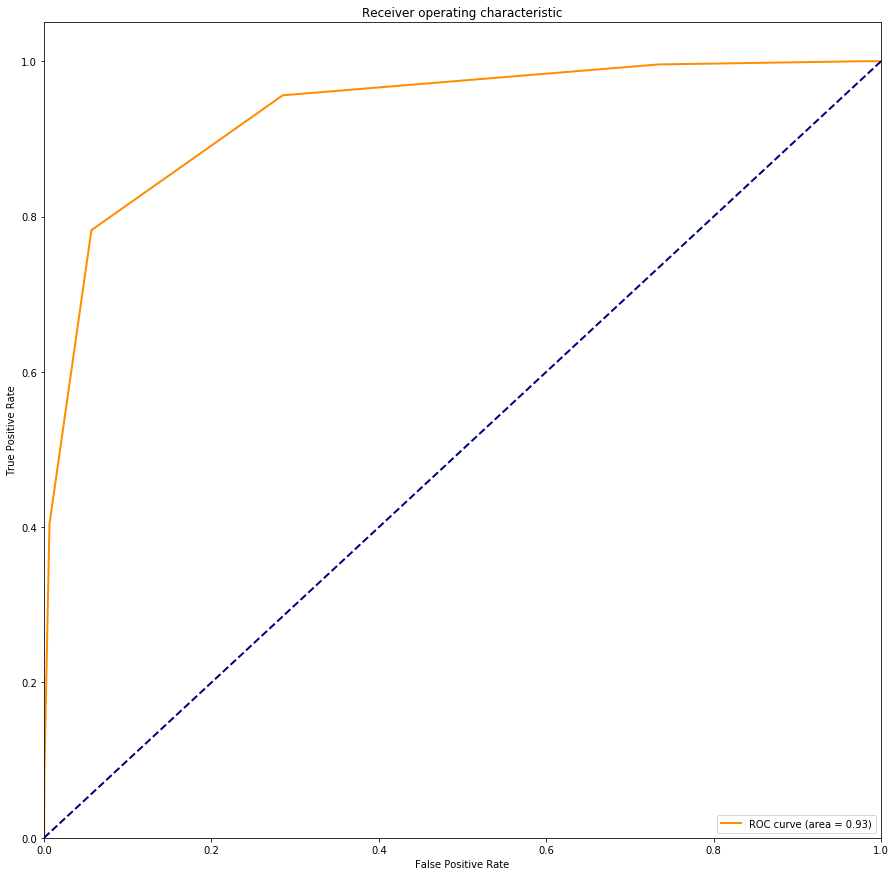

In [114]:
from sklearn.metrics import roc_curve, auc

roc_auc = auc(df_prediction_model['False Positive Rate'], df_prediction_model['True Positive Rate'])
plt.figure()
lw = 2
plt.plot(df_prediction_model['False Positive Rate'].values, df_prediction_model['True Positive Rate'].values, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.rcParams["figure.figsize"] = [15,15]
plt.show()


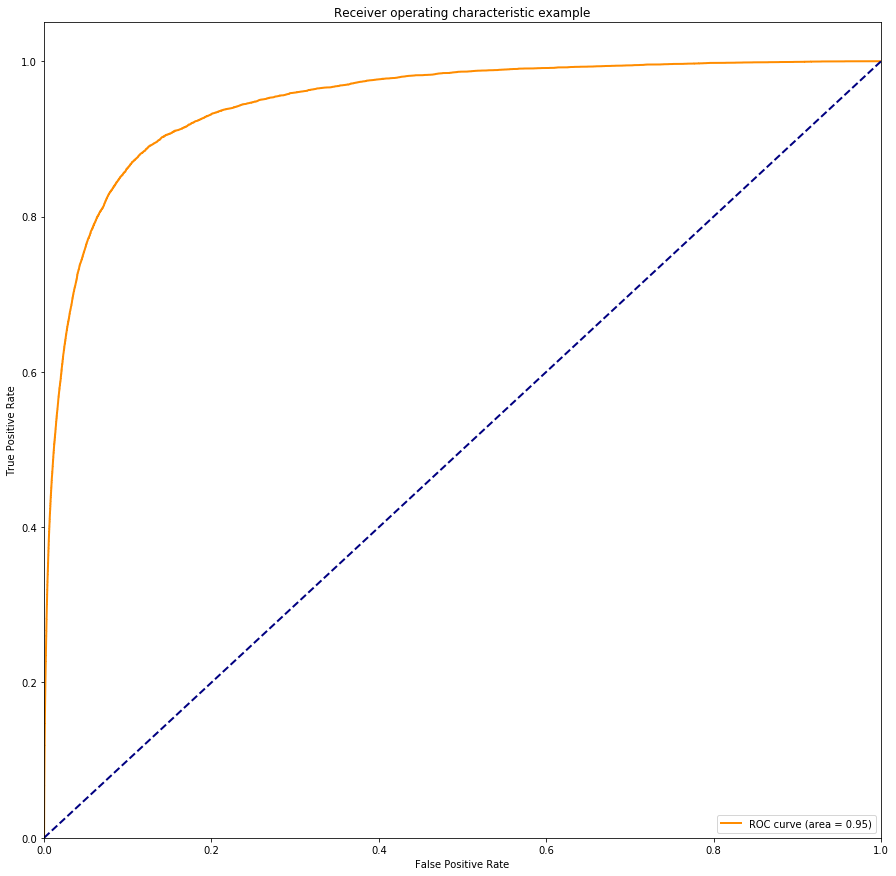

In [115]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(results['Is_Actual_Paragraph']
                                         ,results['neighbor_cos_similarity'])
roc_auc = auc(fpr,tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [116]:
# average_precision = []
# for index, row in df_prediction_model.iterrows():
    

In [74]:
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(results['Is_Actual_Paragraph'], results['neighbor_cos_similarity'])

In [75]:
average_precision

0.03569548189148938

Text(0.5,1,'2-class Precision-Recall curve: AP=0.04')

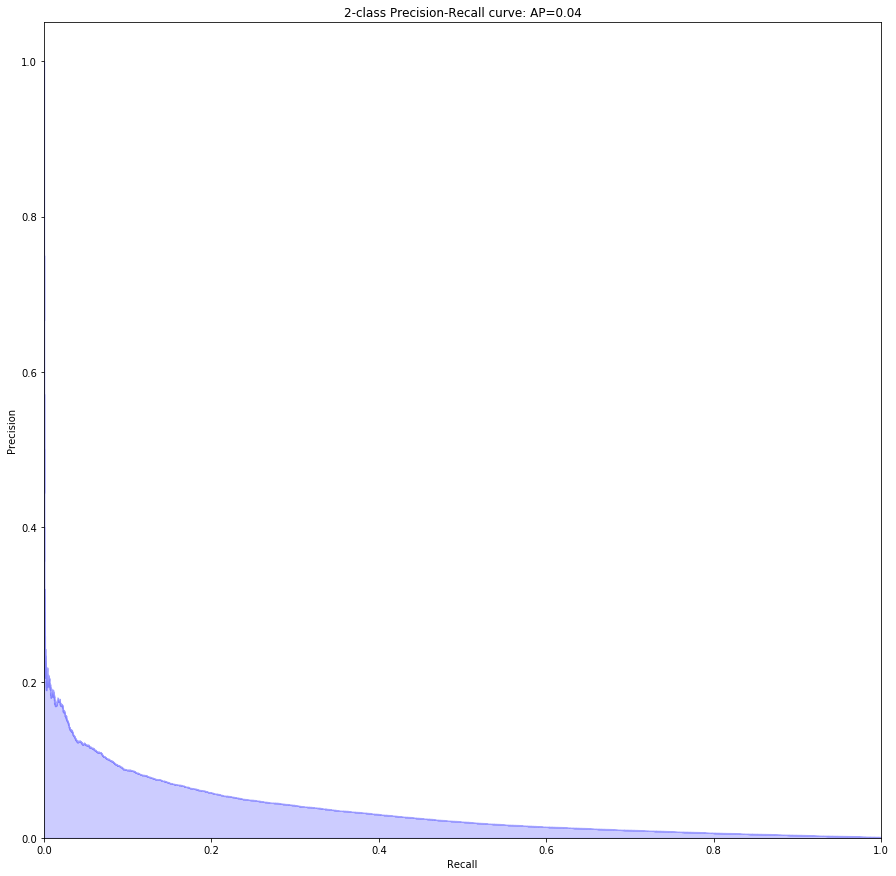

In [117]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

average_precision = average_precision_score(results['Is_Actual_Paragraph'], results['neighbor_cos_similarity'])
precision, recall, _ = precision_recall_curve(results['Is_Actual_Paragraph'], results['neighbor_cos_similarity'])

plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))

In [78]:
_

array([0.21356171, 0.21356174, 0.21356194, ..., 0.84552014, 0.85317624,
       0.85514945])

In [84]:
_cut_off = 0
total_zeros = results.groupby(['Is_Actual_Paragraph']).count()[grouped.index == 0]['slice_type'].values[0]
total_1s = results.groupby(['Is_Actual_Paragraph']).count()[grouped.index == 1]['slice_type'].values[0]
grouped_greater = results[results['neighbor_cos_similarity'] >= _cut_off].groupby(['Is_Actual_Paragraph']).count()
try:
    true_positive = grouped_greater[grouped_greater.index == 1]['slice_type'].values[0]
except:
    true_positive = 0

grouped_smaller = results[results['neighbor_cos_similarity'] < _cut_off].groupby(['Is_Actual_Paragraph']).count()
try:
    true_negative = grouped_smaller[grouped_smaller.index == 0]['slice_type'].values[0]
except:
    true_negative = 0 

try:
    false_positive = grouped_greater[grouped_greater.index == 0]['slice_type'].values[0]
except:
    false_positive = 0

try:
    false_negative = grouped_smaller[grouped_smaller.index == 1]['slice_type'].values[0]
except:
    false_negative = 0

true_negative_rate = (true_negative/total_zeros)
false_positive_rate = 1 - true_negative_rate
true_positive_rate = (true_positive/total_1s)
try:
    precision = true_positive / (true_positive + false_positive)
except:
    precision = 0

try:
    recall = true_positive / (true_positive + false_negative)
except:
    recall = 0
    
    

In [85]:
grouped_greater

,slice_type,question,neighbor_paragraph,neighbor_order,neighbor_cos_similarity,actual_paragraph,actual_paragraph_order,actual_paragrraph_cos_similarity
Is_Actual_Paragraph,,,,,,,,
0,21837620,21837620,21837620,21837620,21837620,21837620,21837620,21837620
1,10570,10570,10570,10570,10570,10570,10570,10570


In [86]:
grouped_smaller

,slice_type,question,neighbor_paragraph,neighbor_order,neighbor_cos_similarity,actual_paragraph,actual_paragraph_order,actual_paragrraph_cos_similarity
Is_Actual_Paragraph,,,,,,,,


In [87]:
false_positive

21837620

In [88]:
false_negative

0

In [89]:
true_positive

10570

In [90]:
true_negative

0